In [183]:
%matplotlib notebook

In [184]:
import torch
import numpy as np
from torch import nn

import math
from matplotlib import pyplot as plt

In [185]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from scipy.stats import entropy as KLD

def GAN_Metric(model,real,fake):
    dist, index  = model.kneighbors(fake,n_neighbors=5,return_distance=True)
    
    diversity = np.zeros(real.shape[0])
    for item in index:
        diversity[item] += 1
    diversity = KLD(diversity, fake.shape[0]*5/fake.shape[0]*np.ones(real.shape[0]))
        
    closeness = dist[:,1].mean()
    
    return diversity, closeness

In [186]:
latent_dimension = 8

In [187]:
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.rand(train_data_length)*2-1
train_data[:, 1] = torch.abs(torch.sin(math.pi * train_data[:, 0]))
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

knn_model = KNN(n_neighbors = 5)
knn_model.fit(train_data.numpy(),np.zeros(train_data.shape[0]))

KNeighborsClassifier()

<IPython.core.display.Javascript object>


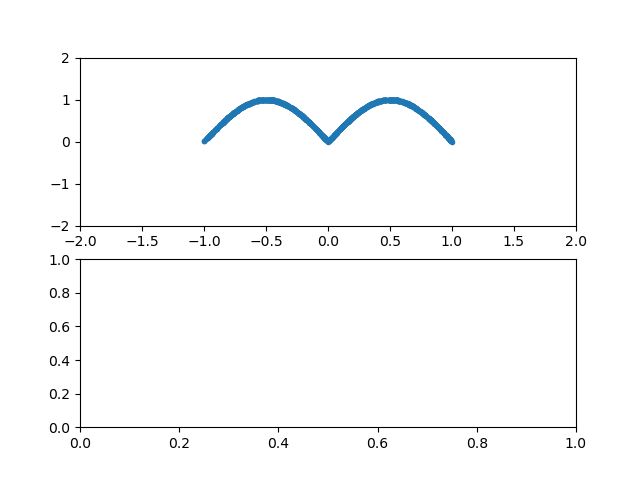

In [188]:
fig, axs = plt.subplots(2)
axs[0].set_xlim(-2,2)
axs[0].set_ylim(-2,2)
axs[0].plot(train_data[:, 0], train_data[:, 1], ".")

In [189]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [190]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [191]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dimension, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [192]:
generator = Generator()
discriminator = Discriminator()

In [193]:
lr = 0.0001
num_epochs = 5000
loss_function = nn.BCELoss()

In [194]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

<IPython.core.display.Javascript object>


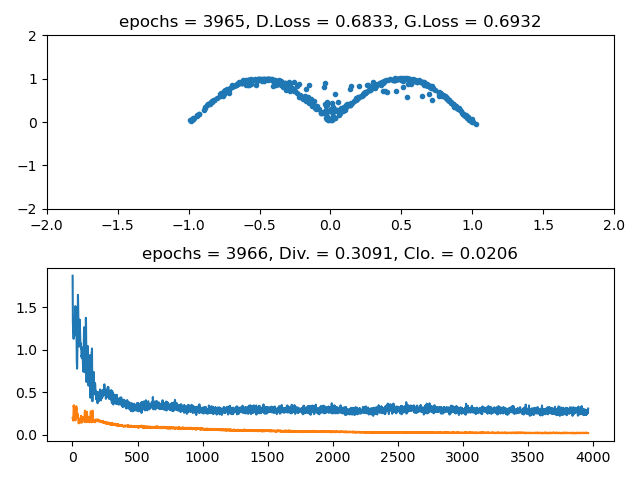

In [ ]:
fig,axs=plt.subplots(2)

epo = []
div = []
clo = []

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, latent_dimension))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, latent_dimension))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        # if epoch % 10 == 0 and n == batch_size - 1:
        #     print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
        #     print(f"Epoch: {epoch} Loss G.: {loss_generator}")
    
    latent_space_samples = torch.randn((512, latent_dimension))
    generated_samples = generator(latent_space_samples)
    data = np.array(generated_samples.tolist())
    
    diversity, closeness = GAN_Metric(model=knn_model ,real=train_data, fake=data)
    
    epo.append(epoch+1)
    div.append(diversity)
    clo.append(closeness)
    
    axs[0].cla()
    axs[0].plot(data[:, 0], data[:, 1], ".")
    axs[0].set_title('epochs = %d, D.Loss = %.4f, G.Loss = %.4f'%(epoch,loss_discriminator,loss_generator))
    axs[0].set_xlim(-2,2)
    axs[0].set_ylim(-2,2)
    
    axs[1].cla()
    axs[1].plot(epo,div)
    axs[1].plot(epo,clo)
    axs[1].set_title('epochs = %d, Div. = %.4f, Clo. = %.4f'%(epo[-1],div[-1],clo[-1]))
    
    plt.tight_layout()
    
    fig.canvas.draw()